In [3]:
from nltk.corpus import stopwords
import re
import operator
import networkx as nx
import numpy as np
import scipy.spatial.distance as scidis

sw = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 
      "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 
      'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 
      'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 
      'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 
      'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be',
      'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 
      'a', 'an', 'the', 'and', 'but', 'because', 'as', 'until', 'while', 
      'of', 'at', 'by', 'for', 'with', 'into', 'through', 
      'during', 'to', 'from', 'then', 'once', 
      'there', 'any', 'both', 'each',
      'most', 'some', 'such', 'nor', 'own', 'so', 
      'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', 
      "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 
      'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
      "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', 
      "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
      "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

KEY_SET = {'`','~','1','2','3','4','5','6','7','8','9','0','-','=','del','!','@','#','$','%','^','&','*',
          '(',')','_','+','tab','q','w','e','r','t','y','u','i','o','p','{','}','[',']','|','\\','caps',
          'a','s','d','f','g','h','j','k','l',':',';','\"', '\'','ret','shift','z','x','c','v','b','n',
          'm',',','.','/','<','>','?','esc','up','down','left','right','spc',''}

KEY_REPLACE = {'delete':'del', 'backspace':'del', 'return':'ret', 'enter':'ret'}


MODIFIER = {'C-', 'C-M-', 'C-M-S-', 'C-S-', 'M-', 'M-S-', 'S-'}

class KeyBinding:

    def __init__(self, key, func, description):
        
        if key == None:
            self.key = key
        else:
            self.key = KeyBinding.remove_bracket(key)
            
        self.func = func
        
        self.description = description
    
    def get_comparable_key(self):
        
        prefix = self.get_prefix()
        suffix = self.get_modifier() + self.get_lastkey()
        
        if prefix:
        
            return prefix + ' ' + suffix
        
        return suffix
        
    def get_summary(self):

        return self.description[:self.description.find('.')]
    
    def get_summary_words(self):
    
        return [w for w in re.split('[\n,+\s().\\&\'\"`‘’-]+', self.get_summary()) if w not in sw]
    
    def get_description_words(self):
        
        return [w for w in re.split('[\n,+\s().\\&\'\"`‘’-]+', self.description ) if w not in sw]
        
    @staticmethod
    def remove_bracket( key ):
        
        words = key.split()
        
        for i in range( len(words)):
            
            if words[i].startswith('<') and words[i].endswith('>'):
            
                words[i] = words[i][1:-1]
        
        return ' '.join( words )
            
    def get_prefix(self):
         
        # deal with ESC 
        prefix = ' '.join( self.key.split()[0:-1] )

        return prefix
    
    def get_modifier(self):
        
        suffix = re.split(' ', self.key)[-1]
        
        if self.key[-1] == '-':
            
            lastkey = '-'
            
        else:
            
            lastkey = re.split('[\s,-]+', self.key)[-1]
        
        if len(lastkey) == 1 and lastkey.isupper():
            
            return suffix[:-len(lastkey)].upper() +'S-'
        
            
        return suffix[:-len(lastkey)].upper()
    
    def get_lastkey(self):
        
        if self.key[-1] == '-':
            
            lastkey = '-'
            
        else:
            
            lastkey = re.split('[\s-]+', self.key)[-1]
        
        return lastkey.lower()

    def get_func_words( self ):
        
        return [word for word in self.func.split('-') if word not in sw] 
    
    def get_func_words_w2v(self):
        
        return [word for word in self.func.split('-')] 
    
    def share_words(self, contrast_keybinding):
        
        return set( self.get_func_words() ).intersection( set( contrast_keybinding.get_func_words() ) )
        
def keybinding_preprocess(keybinding):
    
    
    words = re.split('\s+', keybinding.key)
        
    for i in range(len(words)):
            
        if words[i][-1] == '-':
                
            continue
            
        keys = words[i].split('-')
        lastkey = keys[-1]
            
        if lastkey in KEY_REPLACE: 
            lastkey = KEY_REPLACE[lastkey]
                
            words[i] = '-'.join(keys[:-1] + [lastkey])
        
    keybinding.key =  ' '.join(words) 
    
    if set( [w.lower() for w in re.split( '[\s,-]+', keybinding.key)] ).difference(KEY_SET):
        return False
       
    return True

def file_preprocess(filename='all-key-bindings.txt'):
    
    # get rid of keys out of the keyboard
    
    all_key_bindings = []

    with open(filename, 'r') as f:

        key = None
        func = None
        description = ""

        for line in f:

            if line.strip().startswith('========'):
                
                kb = KeyBinding(key, func, description)
                if keybinding_preprocess(kb):
                    all_key_bindings.append(kb)
                    
                key = None
                func = None
                description = ""

                continue

            if key is None:
                key = line.strip()
                continue

            if func is None:
                func = line.strip()
                continue

            description += line

    return all_key_bindings


In [2]:
all_key = file_preprocess()

In [4]:
glove_file = 'glove.6B.300d.txt'
def loadGloveModel(glove_file):
    f = open(glove_file,'r')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    return model

In [5]:
GloveModel = loadGloveModel(glove_file)

In [7]:
v = GloveModel['king'] + GloveModel['woman'] - GloveModel['man']

In [ ]:
def find_nearest(model, v, k):
    
    distance = np.empty()
    
    for w, wv in model.items():
        np.abs(wv - v)

In [6]:
1 - scidis.cosine(GloveModel['weak'], GloveModel['strong'])

0.6232478092654802

In [120]:
QWERTY_LOCATION_RELATION = nx.Graph()
tmp = tuple('0123456789')
QWERTY_LOCATION_RELATION.add_edges_from((tmp[i], tmp[i+1]) for i in range(len(tmp) - 1 ))
QWERTY_LOCATION_RELATION.add_edges_from([('(', ')') , ('{','}'), ('[',']'), ('up', 'down'), ('left', 'right'), 
                                         ('<', '>') ,('-','+'), ('?','/')])

QWERTY_LOCATION_RELATION.add_nodes_from('~`!@#$%^&*()_+\\|,.;\'\":')
QWERTY_LOCATION_RELATION.add_nodes_from(['del','ret','tab','caps','spc'])

class correlation_pack():
    
    def __init__(self, corr, words, prefix_set, lastkey_set):
        
        self.corr = corr
        self.words = words
        self.prefix_set = prefix_set
        self.lastkey_set = lastkey_set
        
    def update_set(self):
        """
        Update prefix_set and lastkey_set.
    
        Remove the prefix or lastkey in their set if there is no edges.
    
        """
        for s in [self.prefix_set, self.lastkey_set]:
       
    
            for i in s.copy():
            
                if len(list(self.corr.predecessors(i))) < 1:
                
                    s.remove(i)
                    
        return self   
    
    def print_info(self):
        
        print('prefix')
        print(self.prefix_set) 
        print('lastkey')
        print(self.lastkey_set)
        
        for w in self.words:
            
            if self.get_successors(w):
                for k in self.get_successors(w):
                    print(w, k)
                    for b in self.get_edge_keybindings(w, k):
                        print(b.key)
                        print(b.func)
                        
    def get_edge_keybindings(self, word, key):
        """
        Return a list of keybindings that connects the word and key in the graph corr.
        
        """
        if self.corr.has_edge(word, key):
            
            edges_dict =  self.corr.get_edge_data(word, key) 
        
            keybindings = [edge_attribute.get('keybinding') for edge_attribute in iter(edges_dict.values())]
            
        else:
            keybindings = []
        
        return keybindings
    
    
    def w2k_sorted_by_num_of_edges(self, words, key):
        
        if len(words) < 1:
            return []
        
        num_of_edges = {w: self.corr.number_of_edges(w, key) for w in words }
        
        
        return sorted( num_of_edges.items(), key=operator.itemgetter(1), reverse=True )
            
    
    def get_successors(self, node):
       
        return list( self.corr.successors(node) )
    
    def get_num_of_edges(self, node1, node2):
        
        if self.corr.has_edge(node1, node2):
            
            return self.corr.number_of_edges(node1, node2)
        
        else:
            
            return 0

        
class Background_KeyBindings():
    
    def __init__(self, all_keybindings):
        
        self.all_keybindings = all_keybindings
        
    def get_all_modifiers(self):
        
        modifiers = set()
        for k in self.all_keybindings:
            m = k.get_modifier()
            if m:
                if m not in modifiers:
                    modifiers.add(m)
        return modifiers
    
    def exist(self, newkey):
        
        if newkey in KEY_SET:
            
            return True
        
        for k in self.all_keybindings:
            
            if newkey == k.get_comparable_key():
                return True
            
            
        return False
    
    def correlation(self, newkey):
        
        """
        We build a graph that the if the func of the newkey share a word with the old key then we add an 
        
        edge between the word and the keybinding ( prefix and lastkey )
        
        """
        contrastkey = self.all_keybindings
        
        corr = nx.MultiDiGraph()
        
        corr.add_nodes_from( newkey.get_func_words() )
        
        prefix_set = set()
        
        lastkey_set = set()
        
        for key in contrastkey:
            
            sharewords = newkey.share_words( key )
            
            if not sharewords:
                    
                    continue
            
            prefix = key.get_prefix()
            lastkey = key.get_lastkey()
            lastkey_set.add( lastkey )
            
            if not prefix:
                
                for u in sharewords:
                    corr.add_edge(u, lastkey , key=key.key, keybinding=key )
                
            else:
                
                prefix_set.add( prefix )
                
                for u in sharewords:
                    for v in [prefix, lastkey]:
                        corr.add_edge( u, v , key=key.key, keybinding=key)
        
        return correlation_pack( corr, newkey.get_func_words() , prefix_set, lastkey_set)
    
    def word2vec_similar_func_name(self, newkey, glovemodel):
        
        
        size = 300
        func_vec = np.zeros(size)
        for w in newkey.get_func_words_w2v() :
            try:
                tmp = GloveModel[w.lower()]
            except KeyError:
                tmp = np.zeros(size)
            func_vec +=tmp
        
        if np.sum(np.absolute(func_vec)) < 1e-5:
            return None
        
        simi = dict()
        
        for k in self.all_keybindings:
            
            func_vec2 = np.zeros(size)
            
            for w in k.get_func_words_w2v() :
                try:
                    tmp = GloveModel[w.lower()]
                except KeyError:
                    tmp = np.zeros(size)
                func_vec2 +=tmp
            
            if np.sum(np.absolute(func_vec2)) > 1e-5:
                
                simi[k] = 1 - scidis.cosine(func_vec, func_vec2)
            
        simi_sorted = sorted(simi.items(), key=operator.itemgetter(1), reverse=True)
        
        return simi_sorted
    
    def word2vec_similar_func_summary(self, newkey, glovemodel):
        
        
        size = 300
        func_vec = np.zeros(size)
        #######
        for w in newkey.get_description_words() :
            try:
                tmp = GloveModel[w.lower()]
            except KeyError:
                tmp = np.zeros(size)
            func_vec +=tmp
        
        if np.sum(np.absolute(func_vec)) < 1e-5:
            return None
        
        simi = dict()
        
        for k in self.all_keybindings:
            
            func_vec2 = np.zeros(size)
            ################
            for w in k.get_description_words() :
                try:
                    tmp = GloveModel[w.lower()]
                except KeyError:
                    tmp = np.zeros(size)
                func_vec2 +=tmp
            
            if np.sum(np.absolute(func_vec2)) > 1e-5:
                
                simi[k] = 1 - scidis.cosine(func_vec, func_vec2)
            
        simi_sorted = sorted(simi.items(), key=operator.itemgetter(1), reverse=True)
        
        return simi_sorted

    
    def similarity_metric(self, newkey, dummy):
        
        func = set( newkey.get_func_words() )
        
        l = len( func )
        
        simi = dict()
        
        for k in self.all_keybindings:
            
            func2 = set( k.get_func_words())
            tmp = 2 * len( func.intersection(func2) ) / (l + len(func2))
            
            simi[k] = tmp
        
        simi_sorted = sorted(simi.items(), key=operator.itemgetter(1), reverse=True) 
        
        return simi_sorted
            
    
    def word_key_correlation_coef(self, word, keys):
         
        
        num_key = len(keys)
        data = []
        if num_key < 1:
            return dict()
        for k in self.all_keybindings:
            x = [word in k.get_func_words()]
            prefix = k.get_prefix()
            lastkey = k.get_lastkey()
            for key in keys:
                x.append(key == prefix or key == lastkey)
            
            data.append(x)
                
        data = np.array(data).T
        data.astype(float)
        
        if np.sum(data[0]) < 1e-10:
            return dict()
        keys_correlation = { keys[i]: np.corrcoef(np.array([data[0], data[i+1]]) )[0][1]  for i in range(num_key)}
        
        keys_sorted = sorted(keys_correlation.items(), key=operator.itemgetter(1), reverse=True) 
        
        return keys_sorted
            
    def key_word_correlation_coef(self, key, words):
         
        
        num_word = len(words)
        data = []
        if num_word < 1:
            return dict()
        for k in self.all_keybindings:
            x = [(key == k.get_prefix() or key == k.get_lastkey())]
            func = k.get_func_words()
            for w in words:
                x.append(w in func)
            
            #if np.sum(np.array(x)) > 0:
            #    print(x)
            data.append(x)
                
        data = np.array(data).T
        data.astype(float)
        
        if np.sum(data[0]) < 1e-10:
            return dict()
        words_correlation = { words[i]: np.corrcoef(np.array([data[0], data[i+1]]) )[0][1]  for i in range(num_word)}
        
        words_sorted = sorted(words_correlation.items(), key=operator.itemgetter(1), reverse=True) 
        
        return words_sorted
   
    @staticmethod
    def entropy(p):
       
        if p < 1e-10 or (1-p) < 1e-10:
            return 0.0
        
        return  - p * np.log2(p) - (1-p) * np.log2(1-p)
    
    def word_key_mutual_info(self, word, keys):
        """
        H(word | key) = \sum p(key = u) H(word| key = u)
        
        """
        num_key = len(keys)
        #print(keys)
        if num_key < 1:
            return dict()
        count_key = np.zeros(num_key)
        count_word_1 = np.zeros(num_key)
        count_word_2 = np.zeros(num_key)
        num = len(self.all_keybindings)
        
        for k in self.all_keybindings:
            for i in range(num_key):
                if keys[i] == k.get_prefix() or keys[i] == k.get_lastkey():
                    count_key[i] +=1
                    if word in k.get_func_words():
                        count_word_1[i] +=1
                else:
                
                    if word in k.get_func_words():
                        count_word_2[i] +=1
        
        p = count_key / num
        
        keys_mutual_info = { keys[i]: - p[i] * Background_KeyBindings.entropy(float(count_word_1[i]) / count_key[i])  - (1-p[i]) * Background_KeyBindings.entropy( float(count_word_2[i])/ (num - count_key[i])) for i in range(num_key)  } 
        
        keys_sorted = sorted(keys_mutual_info.items(), key=operator.itemgetter(1), reverse=True) 
        
        return keys_sorted 
    
    def key_word_mutual_info(self, key, words):
        
        
        num_word = len(words)
        if num_word < 1:
            return dict()
        
        count_word = np.zeros(num_word)
        count_key_1 = np.zeros(num_word)
        count_key_2 = np.zeros(num_word)
        num = len(self.all_keybindings)
        
        for k in self.all_keybindings:
            
            for i in range(num_word):
                
                if words[i] in k.get_func_words():
                    
                    count_word[i] +=1
                    
                    if key == k.get_prefix() or key == k.get_lastkey():
                        
                        count_key_1[i] += 1
                        
                else:
                    
                    if key == k.get_prefix() or key == k.get_lastkey():
                
                        count_key_2[i] +=1
        
        p = count_word / num
       
        words_mutual_info = {words[i]: - p[i] * Background_KeyBindings.entropy(float(count_key_1[i]) / count_word[i])  - (1-p[i]) * Background_KeyBindings.entropy( float(count_key_2[i])/ (num - count_word[i])) for i in range(num_word) }
        
        words_sorted = sorted(words_mutual_info.items(), key=operator.itemgetter(1), reverse=True) 
        
        return words_sorted 
    
    def compare_words_info(self, key, word, words):
   
        words_sorted = self.key_word_mutual_info( key, words + [word] )
        
        highest_value = words_sorted[0][1]
        
        if dict(words_sorted)[word] < highest_value:
            
            return False
        return True
    
    def compare_words_corr(self, key, word, words):
        
        words_sorted = self.key_word_correlation_coef( key, words + [word] )
        
        highest_value = words_sorted[0][1]
        
        if dict(words_sorted)[word] < highest_value or dict(words_sorted)[word] < 0:
            
            return False
        
        return True 
    
    def compare_keys(self, word, key, keys):
        
        
        keys_sorted = self.word_key_mutual_info(word, keys + [key])
        
        if keys_sorted[key] < list(keys_sorted.values())[0]:
            return False
        
        return True


In [121]:
def k_nearest_neighbor(newkey, simifunc, GloveModel, n):
    
    
    simi = simifunc(newkey, GloveModel)
    
    num_vote = dict()
    stoke_vote = [dict(),dict(),dict(),dict()]
    
    if not simi:
        return '', ''
    
    for i in range(n):
        
        keys = simi[i][0].key.split()
        num = len(keys)
        
        if num in num_vote:
            num_vote[num] +=1
        else:
            num_vote[num] = 1
            
        for j in range(num):
            
            if keys[j] in stoke_vote[j]:
                stoke_vote[j][keys[j]] +=1
            else:
                stoke_vote[j][keys[j]] =1
    
    
    num_vote_sorted = sorted(num_vote.items(), key=operator.itemgetter(1), reverse=True)
    
    num_selected = num_vote_sorted[0][0]
    
    keys_selected = []
    
    for i in range(num_selected):
        
        key = sorted(stoke_vote[i].items(), key=operator.itemgetter(1), reverse=True)[0][0]
        
        keys_selected.append(key)
        
    kb = KeyBinding(' '.join(keys_selected), None, None)
    
    return kb
    

In [113]:
trykey = KeyBinding( None, 'backward-page', 'Display buffer BUFFER-OR-NAME in the selected window.')

In [66]:
all_key = file_preprocess()

In [67]:
ba = Background_KeyBindings(all_key)

In [68]:
k = k_nearest_neighbor(trykey, ba.similarity_metric, GloveModel, 3)

In [69]:
k.key

'C-x'

In [115]:
def similarity_correlation_word2vec(newkey, simifunc, GloveModel, num):
    
    simi = simifunc(newkey, GloveModel)
    #simi = ba.similarity_metric(newkey)
    
    if not simi:
        return Recommendor_Score(nx.MultiDiGraph , [], dict() , dict()) 
    
    prefix_dict = dict()
    lastkey_dict = dict()
    
    total_num = len(simi)
    i = 0
    while len(prefix_dict) < num and i < total_num:
        key, score = simi[i]
        prefix = key.get_prefix()
        
        if prefix not in prefix_dict:
            
            #print(key.key, key.func, score)
            prefix_dict[prefix] = score
            
        i += 1
        
    i = 0
    while len(lastkey_dict) < num and i < total_num:
        
        key, score = simi[i]
        lastkey = key.get_lastkey()
        
        if lastkey not in lastkey_dict and QWERTY_LOCATION_RELATION.has_node(lastkey):
            #print(key.key, key.func, score)
            lastkey_dict[lastkey] = score
            
            for k in QWERTY_LOCATION_RELATION.neighbors(lastkey): 
                if len(lastkey_dict) < num:
                    lastkey_dict[k] = score
            
        i += 1
            
    return Recommendor_Score(None, None, prefix_dict, lastkey_dict) 
    

In [37]:
all_key = file_preprocess()

In [38]:
trykey = KeyBinding( None, 'backward-page', 'Display buffer BUFFER-OR-NAME in the selected window.')
print(trykey.func)

backward-page


In [1353]:
c = similarity_correlation_word2vec(trykey, ba, GloveModel)

In [1556]:
ba = Background_KeyBindings(all_key)
corr = ba.correlation(trykey)
#corr.print_info()

In [408]:
ba.key_word_correlation_coef('del', ['backward'])

[('backward', 0.40814164016275423)]

In [409]:
ba.key_word_correlation_coef('del', ['kill'])

[('kill', 0.58466024096698166)]

In [287]:
tm = correlation_score(trykey, all_key)

In [8]:
class Recommendor_Score():
    
    def __init__(self, score_graph, words, prefix, lastkey):
        
        self.score_graph = score_graph
        self.words = words
        self.prefix_set = prefix
        self.lastkey_set = lastkey
    
    def get_lastkey_score(self, key):
        if key not in self.lastkey_set:
            return 0.0
        else:
            return self.lastkey_set[key]
    
    def has_lastkey(self, key):
        
        if key in self.lastkey_set:
            return 1.0
        else:
            return 0.0
        
    def get_score(self, node1, node2):
        
        return self.score_graph[node1][node2][0]['score'] if self.score_graph.has_edge(node1,node2) else -1.0
    
    def get_successors(self, node):
       
        return list( self.score_graph.successors(node) )
    
    def compare_words(self, word1, word2, key):
       
        """
        Return ture if word1 - word2 > 0
        
        """
        if not self.score_graph.has_node(key):
            
            return False
            
        return self.get_score(word1, key) > self.get_score(word2, key)
    
    def print_info(self):
        print('prefix_set')
        print(self.prefix_set)
        print('lastkey_set')
        print(self.lastkey_set)
        
        for w in self.words:
            if self.get_successors(w):
                for k in self.get_successors(w):
                    print(w, k)
                    print(self.get_score(w, k))
        


In [9]:

# key_name_map first 

QWERTY_KEY_NAME_MAP = {'return': 'ret', 'space': 'spc', 'parenthesis': ')', 'colon': ':', 'delete':'del',
                      'one': '1', 'two': '2', 'three': '3', 'four':'4', 'five':'5', 'six':'6', 'seven':'7', 
                      'eight':'8', 'night':'9', 'zero':'0', 'up':'up', 'down':'down', 'left':'left', 
                       'right':'right','backspace':'del','star':'*','slash':'/','pound':'#','brace':'{'}


def name_key(corr, lastkey_set, words, ba):
    
    for w in words:
      
        if w in QWERTY_KEY_NAME_MAP:
            key = QWERTY_KEY_NAME_MAP[w]
            
            score = 1.0
            
            corr.add_edge(w, key, score = score)
            lastkey_set[key] = score
        
        
        score = 1.0
        
        corr.add_edge(w, w[0].lower() , score = score)
        lastkey_set[w[0].lower()] = score
    
    return corr, lastkey_set

def customized_correlation(newkey, ba):
    
    words = newkey.get_func_words()
    
    corr_score = nx.MultiDiGraph()
    
    lastkey_set = dict()
    
    name_key(corr_score, lastkey_set, words, ba)
    
    return Recommendor_Score(corr_score, words, set(), lastkey_set)

In [10]:
def compare_word_correlation(key, word, words, ba):
    """
    return true if word >= words
    """
    
    newkey = KeyBinding(None, '-'.join([word] + words), None) 
            
    if ba.compare_words_corr(key, word, words):
        return True
    
    return False 
    
    

In [11]:
def correlation_coef(newkey, all_key):
    
   
    func_words = newkey.get_func_words()
    
    ba = Background_KeyBindings(all_key)
    corr = ba.correlation(newkey) 
   
    lastkey_set = dict()
    
    for k in corr.lastkey_set:
        for w in func_words:
            
            keybindings = corr.get_edge_keybindings(w, k)
            
            if keybindings:
                
                for keybinding in keybindings:
                    
                    other_words = keybinding.get_func_words()
                    other_words.remove(w)
                        
                    if not compare_word_correlation(k, w, other_words, ba):
                        name = keybinding.key 
                        corr.corr.remove_edge(w, k, key=name)
           
    corr.update_set()
    
    for k in corr.lastkey_set:
        tmp = 0
        for w in func_words:
            tmp += corr.get_num_of_edges(w,k)
        if tmp > 0:
            lastkey_set[k] = tmp
            
    return Recommendor_Score(None, None, set(), lastkey_set )        
        


In [12]:
def total_recommend(trykey, all_key, simifunc, n, p0, p1, p2, p3):
    
    ba = Background_KeyBindings(all_key)
    si = similarity_correlation_word2vec(trykey, simifunc, GloveModel, n)
    corr = correlation_coef(trykey, all_key)
    cust = customized_correlation(trykey, ba)
    
    lastkey = set(si.lastkey_set).union(set(corr.lastkey_set), set(cust.lastkey_set))
    
    lastkey_dict = dict()
    prefix_dict = dict()
    
    
    if lastkey:
            
        for k in lastkey:
        
            lastkey_dict[k] = p0*( si.has_lastkey(k) + cust.has_lastkey(k) + corr.has_lastkey(k) - 1 ) + p3 * si.get_lastkey_score(k) + p1 * corr.get_lastkey_score(k) + p2 * cust.get_lastkey_score(k) 
    
    return Recommendor_Score(None, None, si.prefix_set.copy(), lastkey_dict )

In [13]:
def normalized_score(s):
    
    t = 0
    n = len(s)
    if n < 1:
        return s
    
    for k in s:
        t += s[k]
        
    t = float(t) / n
    
    if t < 1e-5:
        return s
    
    for k in s:
        s[k] = s[k]/t
    return s

In [14]:
def rank_score(s):
    
    s_tmp = sorted(s.items(), key=operator.itemgetter(1), reverse=True)  
    
    s_sorted = dict()
    
    for i in range(len(s_tmp)):
        s_sorted[s_tmp[i][0]] = i
    
    return s_sorted
        

In [15]:
def sort_naive_prefix_lastkey(prefix, lastkey):
    
    rank_prefix = rank_score(prefix)
    rank_lastkey = rank_score(lastkey)
    
    
    keybinding = dict()
    
    for p in rank_prefix:
        for l in rank_lastkey:
             keybinding[(p,l)] = rank_prefix[p] + rank_lastkey[l]
    

    keybinding_sorted = sorted(keybinding.items(), key=operator.itemgetter(1), reverse=False)  
    
    return keybinding_sorted
    

In [16]:
def sort_prefix_lastkey(prefix, lastkey):
    
    normalized_score(prefix)
    normalized_score(lastkey)
    
    keybinding = dict()
    
    for p in prefix:
        for l in lastkey:
             keybinding[(p,l)] = prefix[p] + lastkey[l]
    
    keybinding_sorted = sorted(keybinding.items(), key=operator.itemgetter(1), reverse=True)  
    
    return keybinding_sorted

In [17]:
def reconstruct_key(prefix, normal_key, modifier):
    
    if prefix:
        
        return prefix+' '+modifier+normal_key
    
    return modifier+normal_key

In [18]:
def rank_recommender(key_sorted, n , ba):
    
    rank_list = []
    
    for k in key_sorted:
        
        prefix = k[0][0]
        lastkey = k[0][1]
        tmp = 0
        combined_set = []
        key = reconstruct_key(prefix, lastkey, '')
        
        if key not in KEY_SET and not ba.exist(key):
            combined_set.append(key)
        for m in MODIFIER:
            key = reconstruct_key(prefix, lastkey, m)
            if not ba.exist(key):
                combined_set.append(key)
                
        if combined_set:
            
            rank_list.append(((prefix, lastkey), combined_set))
    
    return rank_list[:n]
            

In [92]:
def k_near_test(all_key):
    
    num = len(all_key)
    
    
    p = 11
    
    result = []
    for n in range(1,p):
    
        count = 0
    
        all_count = 0
        
        for i in range(num):
        
            key = all_key[i]
            if key.get_comparable_key() in KEY_SET:
                continue
            trykey = KeyBinding(None, key.func, key.description) 
            all_key.pop(i)
        
            ba = Background_KeyBindings(all_key)
    
            key_suggest = k_nearest_neighbor(trykey, ba.similarity_metric, GloveModel, n)
        
            if key.get_prefix() == key_suggest.get_prefix() and key.get_lastkey() == key_suggest.get_lastkey():
            
                all_count +=1
        
            all_key.insert(i, key)
            count +=1   
        
        result.append(all_count/count)
    
    return result

In [93]:
all_key = file_preprocess()

In [94]:
RESULT_knear_metric = k_near_test(all_key)

In [137]:
'&'.join('{:0.3}'.format(i) for i in RESULT_knear_metric)

'0.128&0.128&0.11&0.115&0.105&0.115&0.107&0.107&0.0972&0.0921'

In [122]:
def combined_test(all_key):
    
    
    m = 20 
    num = len(all_key)
    
    all_count = np.zeros(m)
       
    count = 0
    
    for i in range(num):
        
        key = all_key[i]
        if key.get_comparable_key() in KEY_SET:
            continue
        trykey = KeyBinding(None, key.func, key.description) 
        all_key.pop(i)

        ba = Background_KeyBindings(all_key)
        tot = total_recommend(trykey, all_key, ba.word2vec_similar_func_summary, m, 0.0, 1.0, 2.0, 1.0)
        
        sorted_key = sort_prefix_lastkey(tot.prefix_set, tot.lastkey_set)
        
        #rank_list = rank_recommender(sorted_key, m, ba)
        
        prefix = key.get_prefix()
        lastkey = key.get_lastkey()
        for n in range(1,m+1):
            
            tmp_list = sorted_key[:n]
            
            
            for item in tmp_list:
                if prefix == item[0][0] and lastkey == item[0][1]:
                    all_count[n-1] +=1
                    break
            #for item in tmp_list:
                #if key.get_comparable_key() in set(item[1]):
                 #   all_count[n-1] += 1
                  #  break
            
                
        
        all_key.insert(i, key)
        count +=1
        
        
    print('num = {}'.format(count))
    print(all_count/count)
    
    return all_count/count
    
        
        
        
    

In [123]:
all_key = file_preprocess()

In [124]:
RESULT_func_description = combined_test(all_key)

num = 391
[ 0.19181586  0.24808184  0.29411765  0.32225064  0.32992327  0.34015345
  0.35294118  0.36061381  0.36828645  0.37340153  0.37595908  0.37595908
  0.37595908  0.37851662  0.38107417  0.38107417  0.38363171  0.38363171
  0.38363171  0.38363171]


In [125]:
RESULT_func_description

array([ 0.19181586,  0.24808184,  0.29411765,  0.32225064,  0.32992327,
        0.34015345,  0.35294118,  0.36061381,  0.36828645,  0.37340153,
        0.37595908,  0.37595908,  0.37595908,  0.37851662,  0.38107417,
        0.38107417,  0.38363171,  0.38363171,  0.38363171,  0.38363171])

In [119]:
RESULT_func_summary 

array([ 0.2173913 ,  0.28132992,  0.32736573,  0.34526854,  0.35294118,
        0.35549872,  0.36061381,  0.37340153,  0.37595908,  0.37851662,
        0.37851662,  0.37851662,  0.38107417,  0.38618926,  0.3887468 ,
        0.3887468 ,  0.3887468 ,  0.39130435,  0.39130435,  0.39130435])

In [109]:
RESULT_metric

array([ 0.18414322,  0.30946292,  0.37340153,  0.40664962,  0.43478261,
        0.47570332,  0.50383632,  0.52173913,  0.53452685,  0.54731458,
        0.5601023 ,  0.58056266,  0.58567775,  0.59846547,  0.60613811,
        0.60869565,  0.61636829,  0.61892583,  0.61892583,  0.62404092])

In [104]:
RESULT_func_name

array([ 0.20204604,  0.27109974,  0.32736573,  0.35549872,  0.37340153,
        0.38618926,  0.40664962,  0.41432225,  0.41943734,  0.42455243,
        0.42710997,  0.43222506,  0.43734015,  0.44245524,  0.45012788,
        0.46547315,  0.47058824,  0.47314578,  0.47314578,  0.48337596])

In [115]:
RESULT_func_description

array([ 0.18414322,  0.24296675,  0.29667519,  0.32736573,  0.33503836,
        0.34015345,  0.34526854,  0.36061381,  0.3657289 ,  0.37084399,
        0.37340153,  0.37595908,  0.37595908,  0.37851662,  0.38107417,
        0.38107417,  0.38363171,  0.38363171,  0.38618926,  0.38618926])

In [81]:
RESULT_func_summary

array([ 0.21227621,  0.27877238,  0.32225064,  0.342711  ,  0.34782609,
        0.35549872,  0.36061381,  0.37340153,  0.37595908,  0.37851662,
        0.37851662,  0.37851662,  0.38107417,  0.38618926,  0.3887468 ,
        0.3887468 ,  0.3887468 ,  0.39130435,  0.39386189,  0.39386189])

In [53]:
RESULT_naive_func_name

array([ 0.19181586,  0.30690537,  0.36061381,  0.42455243,  0.45780051,
        0.47826087,  0.52429668,  0.54475703,  0.5601023 ,  0.56265985,
        0.57544757,  0.5831202 ,  0.58567775,  0.59590793,  0.60102302,
        0.61636829,  0.62915601,  0.63171355,  0.6342711 ,  0.64450128])

In [23]:
RESULT_func_name

array([ 0.19181586,  0.27365729,  0.32480818,  0.35549872,  0.37084399,
        0.38618926,  0.40153453,  0.41432225,  0.41943734,  0.42455243,
        0.42966752,  0.43478261,  0.4398977 ,  0.44245524,  0.45268542,
        0.46547315,  0.47058824,  0.47314578,  0.47314578,  0.48337596])

In [107]:
RESULT_rank_simi_metric

array([ 0.17647059,  0.31202046,  0.37851662,  0.41176471,  0.43222506,
        0.47314578,  0.50639386,  0.52429668,  0.53964194,  0.55242967,
        0.56521739,  0.58823529,  0.59079284,  0.60102302,  0.6112532 ,
        0.61381074,  0.61892583,  0.62404092,  0.62404092,  0.62404092])

In [103]:
RESULT_navie_rank_simi_metric 

array([ 0.17647059,  0.29667519,  0.35805627,  0.42455243,  0.45524297,
        0.47314578,  0.50383632,  0.51918159,  0.55242967,  0.5601023 ,
        0.57033248,  0.58056266,  0.59335038,  0.59846547,  0.60613811,
        0.61636829,  0.62148338,  0.62915601,  0.63938619,  0.64194373])

In [69]:
RESULT_rank_simi_metric

array([ 0.1713555 ,  0.30946292,  0.3657289 ,  0.40409207,  0.43222506,
        0.46547315,  0.48849105,  0.50639386,  0.52685422,  0.54219949])

In [130]:
def lastkey_test(all_key):
    
    num = len(all_key)
    
    all_count_lastkey = np.zeros(10)
       
    count = 0
    
    for i in range(num):
        
        key = all_key[i]
        if key.get_comparable_key() in KEY_SET:
            continue
        trykey = KeyBinding(None, key.func, key.description) 
        all_key.pop(i)
            
        ba = Background_KeyBindings(all_key)
        tot = total_recommend(trykey, all_key, ba.similarity_metric, 10, 0.0, 1.0, 1.0, 0.0)
        #tot = customized_correlation(trykey, ba)   
        
        #tot = correlation_coef(trykey, all_key)
        #tot = similarity_correlation_word2vec(trykey, ba.word2vec_similar_func_name , GloveModel, 10)
        #print(tot.lastkey_set)
        
        for n in range(1,11):
            nn = min( len(tot.lastkey_set), n)
            
            #if not tot.lastkey_set:
             #   break
            lastkey_sorted = sorted(tot.lastkey_set.items(), key=operator.itemgetter(1), reverse=True)[:nn]
            
            if key.get_lastkey() in dict(lastkey_sorted):
                all_count_lastkey[n-1] +=1
        
            #else:
                #print('False Prefix')
            #print(si.prefix_set)
            #print('================================')
        all_key.insert(i, key)
        count +=1
        #print(lastkey_sorted)
    print('num = {}'.format(count))
    print(all_count_lastkey)
    
    return all_count_lastkey/count
            

In [479]:
argument = 0.0,1.0,2.0,0.0

In [131]:
all_key = file_preprocess()

In [132]:
RESULT_LASTKEY_METRIC= lastkey_test(all_key)

num = 391
[ 106.  194.  234.  253.  262.  273.  274.  284.  290.  294.]


In [129]:
RESULT_LASTKEY_METRIC

array([ 0.28644501,  0.47570332,  0.61892583,  0.64705882,  0.67263427,
        0.69309463,  0.69820972,  0.72890026,  0.74168798,  0.75191816])

In [506]:
RESULT_LASTKEY_METRIC

array([ 0.31202046,  0.49360614,  0.60102302,  0.63682864,  0.67519182,
        0.69053708,  0.71355499,  0.74680307,  0.75703325,  0.76982097])

In [501]:
RESULT_LASTKEY_FUNC_DES

array([ 0.30690537,  0.48849105,  0.59846547,  0.63682864,  0.67519182,
        0.70332481,  0.72890026,  0.74680307,  0.75703325,  0.75703325])

In [493]:
RESULT_LASTKEY_FUNC_SUMMARY

array([ 0.31969309,  0.49616368,  0.60102302,  0.64450128,  0.68286445,
        0.7084399 ,  0.74168798,  0.75959079,  0.76214834,  0.76982097])

In [477]:
RESULT_LASTKEY_si

array([ 0.11508951,  0.17391304,  0.18670077,  0.19181586,  0.1943734 ,
        0.19693095,  0.20460358,  0.22762148,  0.22762148,  0.23273657])

In [459]:
RESULT_LASTKEY_naive

array([ 0.21227621,  0.38363171,  0.48337596,  0.49360614,  0.49360614,
        0.49360614,  0.49360614,  0.49360614,  0.49360614,  0.49360614])

In [463]:
RESULT_LASTKEY_corr

array([ 0.22250639,  0.33759591,  0.39386189,  0.42710997,  0.43734015,
        0.44245524,  0.44245524,  0.44245524,  0.44245524,  0.44245524])

In [465]:
RESULT_LASTKEY_FUNC_NAME_ALLp22

array([ 0.31202046,  0.50127877,  0.60102302,  0.63171355,  0.67007673,
        0.69309463,  0.71867008,  0.73657289,  0.74424552,  0.75959079])

In [396]:
print(RESULT_LASTKEY_FUNC_NAME_ALL0)

[ 0.27365729  0.47058824  0.57544757  0.6342711   0.65984655  0.69309463
  0.71355499  0.7314578   0.74424552  0.75959079]


In [413]:
RESULT_LASTKEY_FUNC_NAME_ALLp1dot5

array([ 0.29411765,  0.5140665 ,  0.60869565,  0.63682864,  0.66240409,
        0.68797954,  0.71611253,  0.73657289,  0.74424552,  0.75959079])

In [407]:
print(RESULT_LASTKEY_FUNC_NAME_ALLpdot5)

[ 0.2685422   0.47826087  0.58056266  0.62915601  0.65473146  0.68797954
  0.71355499  0.7314578   0.74424552  0.75959079]


In [391]:
print(RESULT_LASTKEY_FUNC_NAME_ALL1)

[ 0.27877238  0.47570332  0.57544757  0.6342711   0.65984655  0.69309463
  0.71355499  0.7314578   0.74424552  0.75959079]


In [377]:
print(RESULT_LASTKEY_METRIC_ALL1)

[ 0.27365729  0.48081841  0.57544757  0.6342711   0.67007673  0.69565217
  0.71867008  0.74168798  0.75703325  0.76982097]


In [331]:
def prefix_test(all_key):
    
    num = len(all_key)
    result = []
    for n in range(1,10):
        all_count_prefix = 0
    
        count = 0
        for i in range(num):
            key = all_key[i]
            if key.get_comparable_key() in KEY_SET:
                continue
            trykey = KeyBinding(None, key.func, key.description) 
            all_key.pop(i)
        
            #print(key.key)
            #print(key.func)
            ba = Background_KeyBindings(all_key)
            si = similarity_correlation_word2vec(trykey, ba.similarity_metric, GloveModel, n)
    
            if key.get_prefix() in si.prefix_set:
                all_count_prefix +=1
        
            #else:
                #print('False Prefix')
            #print(si.prefix_set)
            #print('================================')
            all_key.insert(i, key)
            count +=1
        print(si.prefix_set)
        print('num = {}'.format(count))
        print('all_prefix = {}'.format(all_count_prefix))
        result.append((n, all_count_prefix/count))
    return result
    

In [332]:
all_key = file_preprocess()

In [333]:
RESULT_PREFIX_METRIC = prefix_test(all_key)

{'C-x': 1.0}
num = 391
all_prefix = 243
{'C-x': 1.0, '': 1.0}
num = 391
all_prefix = 308
{'C-x': 1.0, '': 1.0, 'C-h': 0.0}
num = 391
all_prefix = 347
{'C-x': 1.0, '': 1.0, 'C-h': 0.0, 'C-h 4': 0.0}
num = 391
all_prefix = 362
{'C-x': 1.0, '': 1.0, 'C-h': 0.0, 'C-h 4': 0.0, 'C-x C-k': 0.0}
num = 391
all_prefix = 371
{'C-x': 1.0, '': 1.0, 'C-h': 0.0, 'C-h 4': 0.0, 'C-x C-k': 0.0, 'C-x RET': 0.0}
num = 391
all_prefix = 380
{'C-x': 1.0, '': 1.0, 'C-h': 0.0, 'C-h 4': 0.0, 'C-x C-k': 0.0, 'C-x RET': 0.0, 'C-x ESC': 0.0}
num = 391
all_prefix = 381
{'C-x': 1.0, '': 1.0, 'C-h': 0.0, 'C-h 4': 0.0, 'C-x C-k': 0.0, 'C-x RET': 0.0, 'C-x ESC': 0.0, 'C-x 4': 0.0}
num = 391
all_prefix = 381
{'C-x': 1.0, '': 1.0, 'C-h': 0.0, 'C-h 4': 0.0, 'C-x C-k': 0.0, 'C-x RET': 0.0, 'C-x ESC': 0.0, 'C-x 4': 0.0, 'C-x 5': 0.0}
num = 391
all_prefix = 381


In [287]:
print(RESULT_PREFIX_FUNC_SUMMARY)

[(1, 0.625974025974026), (2, 0.8207792207792208), (3, 0.8831168831168831), (4, 0.9038961038961039), (5, 0.9142857142857143), (6, 0.9246753246753247), (7, 0.935064935064935), (8, 0.9402597402597402), (9, 0.9454545454545454), (10, 0.948051948051948), (11, 0.9532467532467532), (12, 0.9558441558441558), (13, 0.9584415584415584), (14, 0.9584415584415584), (15, 0.961038961038961), (16, 0.961038961038961), (17, 0.961038961038961), (18, 0.961038961038961), (19, 0.961038961038961)]


In [304]:
print(RESULT_PREFIX_FUNC_DESCIPTION)

[(1, 0.629156010230179), (2, 0.7647058823529411), (3, 0.8286445012787724), (4, 0.8900255754475703), (5, 0.9156010230179028), (6, 0.928388746803069), (7, 0.9360613810741688), (8, 0.9386189258312021), (9, 0.9386189258312021), (10, 0.948849104859335), (11, 0.9514066496163683), (12, 0.9565217391304348), (13, 0.959079283887468), (14, 0.9616368286445013), (15, 0.9641943734015346), (16, 0.9667519181585678), (17, 0.9667519181585678), (18, 0.9667519181585678), (19, 0.969309462915601)]


In [279]:
print(RESULT_PREFIX_FUNC_NAME)

[(1, 0.6398963730569949), (2, 0.8031088082901554), (3, 0.8756476683937824), (4, 0.917098445595855), (5, 0.9507772020725389), (6, 0.9637305699481865), (7, 0.9637305699481865), (8, 0.9740932642487047), (9, 0.9740932642487047), (10, 0.9740932642487047), (11, 0.9766839378238342), (12, 0.9766839378238342), (13, 0.9766839378238342), (14, 0.9792746113989638), (15, 0.9792746113989638), (16, 0.9818652849740933), (17, 0.9844559585492227), (18, 0.9844559585492227), (19, 0.9844559585492227)]


In [334]:
print(RESULT_PREFIX_METRIC)

[(1, 0.6214833759590793), (2, 0.7877237851662404), (3, 0.887468030690537), (4, 0.9258312020460358), (5, 0.948849104859335), (6, 0.9718670076726342), (7, 0.9744245524296675), (8, 0.9744245524296675), (9, 0.9744245524296675)]


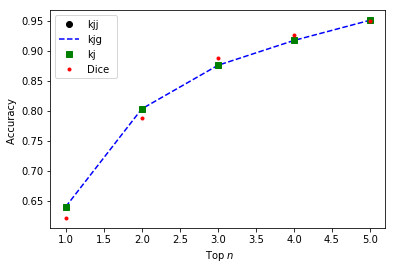

In [350]:
import numpy as np
import matplotlib.pyplot as plt
line1, = plt.plot([k[0] for k in RESULT_PREFIX_FUNC_NAME[:5]], [k[1] for k in RESULT_PREFIX_FUNC_NAME[:5]], 'ko', label = 'kjj')
line2, = plt.plot([k[0] for k in RESULT_PREFIX_FUNC_SUMMARY[:5]], [k[1] for k in RESULT_PREFIX_FUNC_NAME[:5]], 'b--', label = 'kjg')
line3, = plt.plot([k[0] for k in RESULT_PREFIX_FUNC_DESCIPTION[:5]], [k[1] for k in RESULT_PREFIX_FUNC_NAME[:5]], 'gs', label = 'kj')
line4, = plt.plot([k[0] for k in RESULT_PREFIX_FUNC_DESCIPTION[:5]], [k[1] for k in RESULT_PREFIX_METRIC[:5]], 'r.', label = 'Dice ')
plt.xlabel( r' Top $ n $')
plt.ylabel( r'Accuracy ')
plt.legend()
plt.show()

In [224]:
def test2(all_key):
    num = len(all_key)
    all_count_prefix = 0
    all_count_lastkey = 0
    
    for i in range(num):
        key = all_key[i]
        trykey = KeyBinding(None, key.func, key.description) 
        all_key.pop(i)
        
        tot = total_recommend(trykey, all_key)
        print(key.key)
        print(key.func)
        
        if key.get_prefix() in tot.prefix_set:
            all_count_prefix +=1
        else:
            print('False prefix')
        
        if key.get_lastkey() in tot.lastkey_set:
            all_count_lastkey +=1
        else:
            print('False lastkey')
        
        print(tot.prefix_set)
        print(tot.lastkey_set)
        print('================================')
    
        all_key.insert(i, key)
    
    print('num = {}'.format(num))
    print('all_prefix = {}'.format(all_count_prefix))
    print('all_lastkey = {}'.format(all_count_lastkey))

In [125]:
def test(all_key):
   
    
    num = len(all_key)

    corr_count_prefix = 0
    corr_count_lastkey = 0
    cust_count_lastkey = 0
    cust_count_prefix = 0
    empty_count_prefix = 0
    
    simi_count_prefix = 0
    simi_count_lastkey = 0
    
    all_count_prefix = 0
    all_count_lastkey = 0
    
    for i in range(num):
        key = all_key[i]
        trykey = KeyBinding(None, key.func, key.description) 
        all_key.pop(i)
        
        ba = Background_KeyBindings(all_key)
        si = similarity_correlation_word2vec(trykey, ba, GloveModel)
        
        
        corr = correlation_coef(trykey, all_key)
        cust = customized_correlation(trykey, ba)
        print(key.key)
        print(key.func)
       
        if key.get_prefix() in si.prefix_set:
            simi_count_prefix +=1
        if key.get_lastkey() in si.lastkey_set:
            simi_count_lastkey +=1
       
        #print('==============')
        if key.get_prefix() in corr.prefix_set:
            corr_count_prefix +=1
        if key.get_lastkey() in corr.lastkey_set:
            corr_count_lastkey +=1
        
        if key.get_prefix() == '':
            empty_count_prefix +=1
        if key.get_prefix() in cust.prefix_set:
            cust_count_prefix +=1
        if key.get_lastkey() in cust.lastkey_set:
            cust_count_lastkey +=1
        if key.get_prefix() in si.prefix_set or key.get_prefix() in corr.prefix_set or key.get_prefix() in cust.prefix_set or key.get_prefix() == '':
        #if key.get_prefix() in list(corr.prefix_set) + list(cust.prefix_set) + ['']:
            all_count_prefix +=1
        else: 
            print('False for prefix')
            #print(corr.prefix_set)
            #print(cust.prefix_set)
            #print(si.prefix_set)
        if key.get_lastkey() in si.lastkey_set or key.get_lastkey() in corr.lastkey_set or key.get_lastkey() in cust.lastkey_set:
        #if key.get_lastkey() in list(corr.lastkey_set) + list(cust.lastkey_set) + ['']:
            all_count_lastkey +=1
        else:
            print('False for lastkey')
            #print(corr.lastkey_set)
            #print(cust.lastkey_set)
            #print(si.lastkey_set)
        print('prefix')
        print(corr.prefix_set)
        print(cust.prefix_set)
        print(si.prefix_set)
        print('lastkey')
        print(corr.lastkey_set)
        print(cust.lastkey_set)
        print(si.lastkey_set)
        print('================================')
        
        all_key.insert(i,key)
    print('num = {}'.format(num))
    print('empty_prefix = {}'.format(empty_count_prefix))
    print('corr_prefix = {}'.format(corr_count_prefix))
    print('corr_lastkey = {}'.format(corr_count_lastkey))
    print('cust_prefix = {}'.format(cust_count_prefix))
    print('cust_lastkey = {}'.format(cust_count_lastkey))
    print('all_prefix = {}'.format(all_count_prefix))
    print('all_lastkey = {}'.format(all_count_lastkey))
    print('simi_prefix = {}'.format(simi_count_prefix))
    print('simi_lastkey = {}'.format(simi_count_lastkey))
        

In [126]:
all_key = file_preprocess()

In [225]:
def test_one(all_key):
    newkey = KeyBinding(None, 'electric-newline-and-maybe-indent', None)
    
    for i in range(len(all_key) ):
        if all_key[i].func == newkey.func:
            all_key.pop(i)
            break
    tot = total_recommend(newkey, all_key)

    ba = Background_KeyBindings(all_key)
    sorted_key = sort_prefix_lastkey(tot.prefix_set, tot.lastkey_set)
    
    r = rank_recommender(sorted_key, 5, ba)
            
    

In [226]:
test_one(all_key)

In [54]:
all_key = file_preprocess()
test2(all_key)


C-@
set-mark-command
{'': 1.0, 'C-h': 0.4, 'C-x': 0.4}
{'f': 1.0, 'spc': 4.0, '!': 0.4, 'c': 1.0, '@': 4.4, 'tab': 0.3333333333333333, 'm': 1.0, 's': 1.0, 'h': 4.0}
C-a
move-beginning-of-line
{'': 0.6666666666666666, 'C-x': 0.4, 'M-g': 0.4}
{'a': 3.0, 'b': 1.0, ';': 0.4, 'tab': 1.0, 'm': 1.0, 'l': 1.0, '<': 2.4, '>': 0.4}
C-b
backward-char
{'': 0.8, 'C-x 8': 0.5, 'C-x': 0.5}
{'ret': 2.5, '[': 0.5, 'up': 1.0, 'p': 1.0, 'del': 0.8, 'left': 2.0, 'c': 1.0, 'b': 4.0}
C-d
delete-char
{'': 0.8, 'C-x': 0.5, 'C-x 5': 0.5}
{'del': 4.8, 'ret': 1.0, 'c': 1.0, '1': 0.5, '0': 3.5, 'd': 6.0}
C-e
move-end-of-line
{'': 0.6666666666666666, 'C-x': 0.4, 'M-g': 0.4}
{')': 1.0, ';': 0.4, 'e': 6.0, 'tab': 1.0, 'm': 1.0, 'l': 1.0, '<': 0.4, '>': 2.4}
C-f
forward-char
{'': 0.5, 'C-x 8': 0.5, 'C-x': 0.5}
{']': 0.5, 'f': 4.0, 'ret': 2.5, 'n': 1.0, 'right': 2.0, 'c': 1.0, '[': 0.5}
C-g
keyboard-quit
False prefix
False lastkey
{'ESC ESC': 0.8, 'C-h': 0.5, 'C-x RET': 0.3333333333333333}
{'q': 3.0, 'ret': 0.0, '@': 

C-h C-d
view-emacs-debugging
{'C-h': 0.6666666666666666, 'C-x C-k': 0.2857142857142857, '': 0.0}
{'ret': 0.3333333333333333, 'v': 1.0, '@': 0.0, 'e': 1.0, '\\': 0.0, 'd': 1.0}
C-h C-c
describe-copying
{'C-h': 0.5, '': 0.0, 'C-h 4': 0.0}
{'ret': 0.0, 'c': 1.0, '@': 0.0, 'o': 1.0, '\\': 0.4, 'd': 1.0}
C-h C-a
about-emacs
{'C-h': 0.4, '': 0.0, 'C-h 4': 0.0}
{'ret': 0.0, 'a': 1.0, '@': 0.0, 'e': 1.0, '\\': 0.0}
C-h ?
help-for-help
False lastkey
{'C-h': 1.0, '': 0.0, 'C-h 4': 0.0}
{'@': 0.0, '.': 0.5, '\\': 0.0, 'h': 4.0}
C-h .
display-local-help
False lastkey
{'C-h': 0.5, 'C-x 4': 0.4, 'C-x': 0.3333333333333333}
{'$': 0.3333333333333333, 'd': 1.0, 'h': 3.0, 'o': 2.0, '?': 2.5, 'l': 1.0, '/': 0.5}
C-h C-h
help-for-help
{'C-h': 1.0, '': 0.0, 'C-h 4': 0.0}
{'.': 0.5, '?': 4.0, 'h': 1.0, '/': 1.0}
TAB
indent-for-tab-command
{'C-h': 0.4, 'C-x': 0.4, '': 0.4}
{'q': 1.0, '!': 0.4, 't': 1.0, 'c': 1.0, 'i': 3.0, 'tab': 0.4, 'j': 1.0, '\\': 0.4}
C-j
electric-newline-and-maybe-indent
False lastkey
{'

C-x C-k C-t
kmacro-swap-ring
False lastkey
{'C-x C-k': 0.5714285714285714, 'C-x': 0.3333333333333333, '': 0.3333333333333333}
{'r': 1.0, 'ret': 0.3333333333333333, '(': 0.3333333333333333, 'k': 1.0, 'tab': 0.3333333333333333, 's': 1.0}
C-x C-k C-d
kmacro-delete-ring-head
{'C-x C-k': 0.5714285714285714, '': 0.3333333333333333, 'C-x': 0.3333333333333333}
{'1': 0.3333333333333333, '0': 3.333333333333333, 'k': 1.0, '^': 0.3333333333333333, 'del': 3.0, 'r': 1.0, 'd': 5.0, 'h': 1.0}
C-x C-k C-v
kmacro-view-macro-repeat
{'C-x C-k': 0.75, 'C-x': 0.5714285714285714, 'C-h': 0.3333333333333333}
{'r': 1.0, 'ret': 0.5714285714285714, '(': 0.5714285714285714, ')': 0.5714285714285714, 'v': 1.0, 'z': 1.0, 'e': 3.0, 'k': 1.0, 'm': 1.0}
C-x C-k C-p
kmacro-cycle-ring-previous
{'C-x C-k': 0.75, '': 0.3333333333333333, 'C-x': 0.3333333333333333}
{'r': 1.0, 'right': 0.3333333333333333, 'c': 1.0, 'k': 1.0, 'up': 2.333333333333333, 'p': 6.0, 'left': 3.333333333333333}
C-x C-k C-n
kmacro-cycle-ring-next
{'C-x 

C-x ESC ESC
repeat-complex-command
False prefix
False lastkey
{'C-x': 1.0, 'C-h': 0.4, '': 0.4}
{':': 3.0, 'z': 1.0, 'r': 1.0, '!': 0.4, 'v': 1.0, '@': 0.3333333333333333, 'c': 1.0}
C-x SPC
rectangle-mark-mode
{'C-h': 0.4, 'C-x': 0.4, 'C-x r': 0.4}
{'@': 5.4, '+': 2.333333333333333, 'm': 3.0, '-': 0.3333333333333333, 'r': 1.0, 'spc': 3.0, 'l': 2.0, 'h': 4.0}
C-x $
set-selective-display
False prefix
False lastkey
{'C-x 4': 0.4, 'C-x r': 0.4, '': 0.3333333333333333}
{'f': 1.0, '@': 0.3333333333333333, 'o': 2.0, '.': 0.3333333333333333, '\\': 0.3333333333333333, 'd': 1.0, 's': 1.0}
C-x '
expand-abbrev
False prefix
{'C-x a': 1.0, '': 0.5, 'C-c': 0.4}
{'a': 1.0, 'e': 3.0, '?': 0.5, "'": 3.0, '/': 0.5}
C-x (
kmacro-start-macro
{'C-x C-k': 1.0, 'C-x': 0.6666666666666666, 'C-c': 0.3333333333333333}
{'ret': 0.6666666666666666, '(': 0.6666666666666666, ')': 0.6666666666666666, 'e': 3.0, 'k': 1.0, 'm': 1.0, 's': 4.0}
C-x )
kmacro-end-macro
{'C-x': 0.8571428571428571, 'C-x C-k': 0.6666666666666666

KeyboardInterrupt: 

keyboard metric and similarity approach

In [1455]:
test(all_key) 

C-@
set-mark-command
prefix
set()
set()
{'': 1.0, 'C-h': 0.4, 'C-x': 0.4}
lastkey
{'spc': 4, '@': 3, 'h': 3, 'f': 1}
{'s': 1.0, 'm': 1.0, 'c': 1.0}
{'@': 0.4, '!': 0.4, 'tab': 0.3333333333333333}
C-a
move-beginning-of-line
prefix
set()
set()
{'': 0.6666666666666666, 'C-x': 0.4, 'M-g': 0.4}
lastkey
{'tab': 1, 'a': 1, '<': 1}
{'m': 1.0, 'b': 1.0, 'l': 1.0}
{';': 0.4, '<': 0.4, '>': 0.4}
C-b
backward-char
prefix
set()
set()
{'': 0.8, 'C-x 8': 0.5, 'C-x': 0.5}
lastkey
{'b': 2, 'left': 2, 'up': 1, 'del': 1}
{'b': 1.0, 'c': 1.0}
{'del': 0.8, 'ret': 0.5, '[': 0.5}
C-d
delete-char
prefix
set()
set()
{'': 0.8, 'C-x': 0.5, 'C-x 5': 0.5}
lastkey
{'d': 1, '0': 2, 'x': 1}
{'del': 1.0, 'd': 1.0, 'c': 1.0}
{'del': 0.8, '0': 0.5, '1': 0.5}
C-e
move-end-of-line
prefix
set()
set()
{'': 0.6666666666666666, 'C-x': 0.4, 'M-g': 0.4}
lastkey
{')': 1, 'e': 2, '>': 1, 'tab': 1}
{'m': 1.0, 'e': 1.0, 'l': 1.0}
{';': 0.4, '>': 0.4, '<': 0.4}
C-f
forward-char
prefix
set()
set()
{'': 0.5, 'C-x 8': 0.5, 'C-x': 0.5}


C-h C-p
view-emacs-problems
prefix
set()
set()
{'C-h': 0.6666666666666666, 'C-x C-k': 0.2857142857142857, '': 0.0}
lastkey
{}
{'v': 1.0, 'e': 1.0, 'p': 1.0}
{'ret': 0.3333333333333333, '@': 0.0, '\\': 0.0}
C-h C-o
describe-distribution
False for lastkey
prefix
set()
set()
{'C-h': 0.5, '': 0.0, 'C-h 4': 0.0}
lastkey
{'c': 1}
{'d': 1.0}
{'\\': 0.4, '@': 0.0, 'ret': 0.0}
C-h C-n
view-emacs-news
prefix
set()
set()
{'C-h': 1.0, 'C-x C-k': 0.2857142857142857, '': 0.0}
lastkey
{'n': 1}
{'v': 1.0, 'e': 1.0, 'n': 1.0}
{'ret': 0.3333333333333333, '@': 0.0, '\\': 0.0}
C-h RET
view-order-manuals
False for lastkey
prefix
set()
set()
{'C-h': 0.4, 'C-x C-k': 0.2857142857142857, '': 0.0}
lastkey
{}
{'v': 1.0, 'o': 1.0, 'm': 1.0}
{'@': 0.0, '\\': 0.0, '?': 0.0}
C-h C-f
view-emacs-FAQ
prefix
set()
set()
{'C-h': 0.6666666666666666, 'C-x C-k': 0.2857142857142857, '': 0.0}
lastkey
{}
{'v': 1.0, 'e': 1.0, 'f': 1.0}
{'ret': 0.3333333333333333, '@': 0.0, '\\': 0.0}
C-h C-e
view-external-packages
prefix
set()


C-x C-k l
kmacro-edit-lossage
prefix
set()
set()
{'C-x C-k': 0.6666666666666666, 'C-h': 0.4, 'C-x': 0.3333333333333333}
lastkey
{'e': 2, 'ret': 1, 'l': 1}
{'k': 1.0, 'e': 1.0, 'l': 1.0}
{'ret': 0.6666666666666666, 'tab': 0.3333333333333333, '(': 0.3333333333333333}
C-x C-k e
edit-kbd-macro
prefix
set()
set()
{'C-x C-k': 0.6666666666666666, 'C-x': 0.6666666666666666, '': 0.3333333333333333}
lastkey
{'e': 1, 'q': 2, 'ret': 1}
{'e': 1.0, 'k': 1.0, 'm': 1.0}
{'ret': 0.6666666666666666, '(': 0.3333333333333333, ')': 0.3333333333333333}
C-x C-k RET
kmacro-edit-macro
False for lastkey
prefix
set()
set()
{'C-x C-k': 0.8571428571428571, 'C-x': 0.6666666666666666, '': 0.3333333333333333}
lastkey
{'e': 2}
{'k': 1.0, 'e': 1.0, 'm': 1.0}
{'(': 0.6666666666666666, ')': 0.6666666666666666, 'tab': 0.3333333333333333}
C-x C-k C-e
kmacro-edit-macro-repeat
prefix
set()
set()
{'C-x C-k': 0.8571428571428571, 'C-x': 0.5714285714285714, 'C-x ESC': 0.2857142857142857}
lastkey
{'z': 1, 'v': 1, 'ret': 1}
{'k': 

C-x RET F
set-file-name-coding-system
prefix
set()
set()
{'C-x RET': 0.8, 'C-h': 0.5, 'C-x': 0.2857142857142857}
lastkey
{'f': 6, 'n': 1}
{'s': 1.0, 'f': 1.0, 'n': 1.0, 'c': 1.0}
{'@': 0.25, '\\': 0.25, '$': 0.25}
C-x RET r
revert-buffer-with-coding-system
prefix
set()
set()
{'C-x RET': 0.6666666666666666, 'C-h': 0.5714285714285714, 'C-x': 0.3333333333333333}
lastkey
{'u': 1}
{'r': 1.0, 'b': 1.0, 'c': 1.0, 's': 1.0}
{'left': 0.3333333333333333, 'right': 0.3333333333333333, '<': 0.3333333333333333}
C-x RET f
set-buffer-file-coding-system
prefix
set()
set()
{'C-x RET': 0.8, 'C-h': 0.5, 'C-x': 0.2857142857142857}
lastkey
{'f': 6}
{'s': 1.0, 'b': 1.0, 'f': 1.0, 'c': 1.0}
{'left': 0.2857142857142857, 'right': 0.2857142857142857, '<': 0.2857142857142857}
C-x C-n
set-goal-column
False for lastkey
prefix
set()
set()
{'C-x': 0.6666666666666666, 'C-x r': 0.4, 'M-g': 0.4}
lastkey
{'f': 1, 'tab': 1}
{'s': 1.0, 'g': 1.0, 'c': 1.0}
{';': 0.6666666666666666, 'tab': 0.4, '@': 0.3333333333333333}
C-x C

C-x 4 b
switch-to-buffer-other-window
prefix
set()
set()
{'C-x 5': 0.75, 'C-x 4': 0.6666666666666666, 'C-x': 0.6666666666666666}
lastkey
{'o': 2, '0': 1, 'b': 3}
{'s': 1.0, 'b': 1.0, 'o': 1.0, 'w': 1.0}
{'0': 0.5714285714285714, '1': 0.5714285714285714, '~': 0.5}
C-x 4 C-f
find-file-other-window
prefix
set()
set()
{'C-x 4': 1.0, 'C-x 5': 0.75, 'C-x': 0.6666666666666666}
lastkey
{'o': 2, '0': 1, 'f': 7}
{'f': 1.0, 'o': 1.0, 'w': 1.0}
{'.': 0.6666666666666666, '~': 0.5, '0': 0.3333333333333333}
C-x 4 r
find-file-read-only-other-window
prefix
set()
set()
{'C-x 5': 0.8333333333333334, 'C-x': 0.8, 'C-x 4': 0.8}
lastkey
{'o': 2, 'q': 2, '0': 1, 'r': 4, 'f': 8}
{'f': 1.0, 'r': 1.0, 'o': 1.0, 'w': 1.0}
{'.': 0.5454545454545454, '~': 0.4, '0': 0.25}
C-x 4 f
find-file-other-window
prefix
set()
set()
{'C-x 4': 1.0, 'C-x 5': 0.75, 'C-x': 0.6666666666666666}
lastkey
{'o': 2, '0': 1, 'f': 7}
{'f': 1.0, 'o': 1.0, 'w': 1.0}
{'.': 0.6666666666666666, '~': 0.5, '0': 0.3333333333333333}
C-x 4 0
kill-buff

C-x a '
expand-abbrev
prefix
set()
set()
{'C-x': 1.0, 'C-x a': 1.0, '': 0.5}
lastkey
{'e': 1, "'": 1}
{'e': 1.0, 'a': 1.0}
{"'": 1.0, '/': 0.5, '?': 0.5}
C-x a e
expand-abbrev
prefix
set()
set()
{'C-x': 1.0, 'C-x a': 1.0, '': 0.5}
lastkey
{"'": 3}
{'e': 1.0, 'a': 1.0}
{"'": 1.0, '/': 0.5, '?': 0.5}
C-x a -
inverse-add-global-abbrev
prefix
set()
set()
{'C-x a i': 1.0, 'C-x a': 0.8571428571428571, 'C-x': 0.3333333333333333}
lastkey
{'g': 2, 'a': 2, "'": 3}
{'i': 1.0, 'a': 1.0, 'g': 1.0}
{'+': 0.5714285714285714, '-': 0.5714285714285714, "'": 0.3333333333333333}
C-x a i l
inverse-add-mode-abbrev
prefix
set()
set()
{'C-x a': 0.8571428571428571, 'C-x a i': 0.75, 'C-h': 0.3333333333333333}
lastkey
{'+': 1, 'a': 2, '-': 1, 'm': 1, 'l': 1, "'": 3}
{'i': 1.0, 'a': 1.0, 'm': 1.0}
{'+': 0.8571428571428571, '-': 0.8571428571428571, "'": 0.3333333333333333}
C-x a i g
inverse-add-global-abbrev
prefix
set()
set()
{'C-x a': 1.0, 'C-x a i': 0.75, 'C-x': 0.3333333333333333}
lastkey
{'g': 1, 'a': 2, '-':

C-x r s
copy-to-register
False for lastkey
prefix
set()
set()
{'C-x r': 1.0, 'C-x C-k': 0.5, 'C-x v': 0.5}
lastkey
{'r': 1, 'i': 1, 'x': 2}
{'c': 1.0, 'r': 1.0}
{'+': 0.5, '-': 0.5, '@': 0.5}
C-x r j
jump-to-register
prefix
set()
set()
{'C-x C-k': 0.5, 'C-x r': 0.5, 'C-x v': 0.5}
lastkey
{'b': 1, 'i': 1, 'x': 2}
{'j': 1.0, 'r': 1.0}
{'+': 0.5, '-': 0.5, '@': 0.5}
C-x r SPC
point-to-register
prefix
set()
set()
{'C-x r': 1.0, 'C-x C-k': 0.5, 'C-x v': 0.5}
lastkey
{'@': 1, '.': 2, 'spc': 1, 'i': 1, 'x': 2}
{'p': 1.0, 'r': 1.0}
{'@': 1.0, '+': 0.5, '-': 0.5}
C-x r C-SPC
point-to-register
prefix
set()
set()
{'C-x r': 1.0, 'C-x C-k': 0.5, 'C-x v': 0.5}
lastkey
{'@': 1, '.': 2, 'spc': 1, 'i': 1, 'x': 2}
{'p': 1.0, 'r': 1.0}
{'@': 1.0, '+': 0.5, '-': 0.5}
C-x r C-@
point-to-register
False for lastkey
prefix
set()
set()
{'C-x r': 1.0, 'C-x C-k': 0.5, 'C-x v': 0.5}
lastkey
{'.': 2, 'spc': 2, 'i': 1, 'x': 2}
{'p': 1.0, 'r': 1.0}
{'+': 0.5, '-': 0.5, '.': 0.4}
C-x r M-w
copy-rectangle-as-kill
pref

C-x {
shrink-window-horizontally
prefix
set()
set()
{'C-x': 0.6666666666666666, '': 0.4, 'C-h 4': 0.3333333333333333}
lastkey
{'}': 1, '-': 1, '0': 1}
{'s': 1.0, 'w': 1.0, 'h': 1.0}
{'}': 0.6666666666666666, '{': 0.6666666666666666, '-': 0.5}
C-x }
enlarge-window-horizontally
prefix
set()
set()
{'C-x': 0.8, '': 0.4, 'C-h 4': 0.3333333333333333}
lastkey
{'^': 1, '{': 1, '0': 1}
{'e': 1.0, 'w': 1.0, 'h': 1.0}
{'^': 0.8, '{': 0.6666666666666666, '}': 0.6666666666666666}
C-x DEL
backward-kill-sentence
prefix
set()
set()
{'': 0.8, 'ESC': 0.6666666666666666, 'C-x': 0.4}
lastkey
{'b': 3, 'e': 1, 'left': 2, 'k': 5, 'a': 1, 'w': 3, 'up': 1, 'del': 6}
{'b': 1.0, 'k': 1.0, 's': 1.0}
{'del': 0.6666666666666666, '[': 0.4, ']': 0.4}
C-x C-0
text-scale-adjust
False for lastkey
prefix
set()
set()
{'C-x': 1.0, '': 0.0, 'C-h': 0.0}
lastkey
{'-': 3, '=': 3, '+': 3}
{'t': 1.0, 's': 1.0, 'a': 1.0}
{'-': 1.0, '+': 1.0, '@': 0.0}
C-x C-=
text-scale-adjust
False for lastkey
prefix
set()
set()
{'C-x': 1.0, '':

C-M-\
indent-region
False for lastkey
prefix
set()
set()
{'': 0.5, 'C-x': 0.5, 'C-x n': 0.5}
lastkey
{'tab': 1, 'j': 1}
{'i': 1.0, 'r': 1.0}
{'tab': 0.5, 'del': 0.5, '|': 0.3333333333333333}
M-SPC
just-one-space
prefix
set()
set()
{'': 0.4, 'C-h': 0.0, 'C-h 4': 0.0}
lastkey
{'\\': 1}
{'1': 1.0, 'o': 1.0, 'spc': 1.0, 's': 1.0}
{'\\': 0.4, '@': 0.0, 'ret': 0.0}
M-!
shell-command
False for lastkey
prefix
set()
set()
{'': 0.8, 'C-h': 0.5, 'C-x': 0.4}
lastkey
{}
{'s': 1.0, 'c': 1.0}
{'&': 0.8, '|': 0.6666666666666666, '@': 0.4}
M-$
ispell-word
False for lastkey
prefix
set()
set()
{'': 0.5, 'ESC': 0.5, 'M-s': 0.4}
lastkey
{'left': 1, 'd': 1}
{'i': 1.0, 'w': 1.0}
{'@': 0.5, 'left': 0.5, 'right': 0.5}
M-%
query-replace
prefix
set()
set()
{'': 0.8, 'C-x C-k': 0.4, 'C-x': 0.4}
lastkey
{'q': 2, '%': 1}
{'q': 1.0, 'r': 1.0}
{'%': 0.8, '@': 0.0, '\\': 0.0}
M-&
async-shell-command
False for lastkey
prefix
set()
set()
{'': 0.8, 'C-h': 0.4, 'C-x': 0.3333333333333333}
lastkey
{'!': 1}
{'a': 1.0, 's': 1

M-h
mark-paragraph
prefix
set()
set()
{'C-x': 0.5, '': 0.5, 'M-o': 0.5}
lastkey
{'}': 1, '{': 1, 'down': 1, '@': 4, 'h': 1, 'spc': 4}
{'m': 1.0, 'p': 1.0}
{'@': 0.5, '{': 0.5, '}': 0.5}
M-i
tab-to-tab-stop
False for lastkey
prefix
set()
set()
{'': 0.4, 'C-h': 0.0, 'C-h 4': 0.0}
lastkey
{'tab': 2}
{'t': 1.0, 's': 1.0}
{'tab': 0.4, '@': 0.0, '\\': 0.0}
M-j
indent-new-comment-line
prefix
set()
set()
{'': 1.0, 'C-x': 0.6666666666666666, 'M-g': 0.3333333333333333}
lastkey
{';': 3, 'tab': 1, 'j': 1, '\\': 1}
{'i': 1.0, 'n': 1.0, 'c': 1.0, 'l': 1.0}
{';': 0.6666666666666666, 'tab': 0.3333333333333333, '\\': 0.3333333333333333}
M-k
kill-sentence
prefix
set()
set()
{'C-x': 0.8, '': 0.5, 'C-x r': 0.5}
lastkey
{'e': 1, 'k': 4, 'a': 1, 'w': 3, 'del': 6}
{'k': 1.0, 's': 1.0}
{'del': 0.8, '0': 0.4, '1': 0.4}
M-l
downcase-word
prefix
set()
set()
{'C-x': 0.5, '': 0.5, 'ESC': 0.5}
lastkey
{'left': 1, 'd': 1, 'l': 1}
{'d': 1.0, 'w': 1.0}
{'$': 0.5, '@': 0.5, 'left': 0.5}
M-m
back-to-indentation
False fo

M-y
yank-pop
prefix
set()
set()
{'': 0.6666666666666666, 'C-x r': 0.5, 'C-x': 0.4}
lastkey
{'y': 2}
{'y': 1.0, 'p': 1.0}
{'@': 0.4, '\\': 0.0, 'ret': 0.0}
M-z
zap-to-char
prefix
set()
set()
{'': 0.5, 'C-x 8': 0.5, 'M-g': 0.5}
lastkey
{'ret': 1}
{'z': 1.0, 'c': 1.0}
{'ret': 0.5, 'right': 0.5, 'left': 0.5}
M-{
backward-paragraph
False for lastkey
prefix
set()
set()
{'': 1.0, 'C-x': 0.5, 'M-o': 0.5}
lastkey
{'b': 3, '}': 1, 'left': 2, 'up': 1, 'del': 1, 'down': 1}
{'b': 1.0, 'p': 1.0}
{'up': 1.0, 'down': 1.0, '[': 0.5}
M-|
shell-command-on-region
False for lastkey
prefix
set()
set()
{'': 0.6666666666666666, 'C-h': 0.3333333333333333, 'C-x': 0.3333333333333333}
lastkey
{'!': 1}
{'s': 1.0, 'c': 1.0, 'o': 1.0, 'r': 1.0}
{'!': 0.6666666666666666, '&': 0.5714285714285714, '\\': 0.3333333333333333}
M-}
forward-paragraph
False for lastkey
prefix
set()
set()
{'': 1.0, 'C-x': 0.5, 'M-o': 0.5}
lastkey
{'f': 3, '{': 1, 'down': 1, 'right': 3}
{'f': 1.0, 'p': 1.0}
{'down': 1.0, 'up': 1.0, ']': 0.5}
M-

S P C . . ~
self-insert-command
False for prefix
False for lastkey
prefix
set()
set()
{'C-h': 0.4, '': 0.4, 'C-x 8': 0.4}
lastkey
{'g': 1, 'ret': 1, 'i': 2}
{'s': 1.0, 'i': 1.0, 'c': 1.0}
{'ret': 0.4, '!': 0.4, '(': 0.4}
DEL
delete-backward-char
prefix
set()
set()
{'': 0.8, 'C-x': 0.4, 'C-x 5': 0.4}
lastkey
{'d': 2, 'up': 1, 'x': 1, 'left': 2, '0': 2, 'b': 3}
{'del': 1.0, 'd': 1.0, 'b': 1.0, 'c': 1.0}
{'0': 0.4, '1': 0.4, 'ret': 0.4}
c-m-down
down-list
prefix
set()
set()
{'': 1.0, 'ESC': 1.0, 'C-x': 0.5}
lastkey
{'p': 1, 'n': 1, 'd': 1, 'down': 1}
{'down': 1.0, 'd': 1.0, 'l': 1.0}
{'down': 1.0, 'up': 1.0, '@': 0.0}
c-m-up
backward-up-list
prefix
set()
set()
{'': 1.0, 'ESC': 1.0, 'C-x': 0.4}
lastkey
{'b': 3, 'left': 2, 'p': 1, 'u': 1, 'n': 1, 'd': 1, 'up': 2, 'del': 1}
{'b': 1.0, 'up': 1.0, 'u': 1.0, 'l': 1.0}
{'up': 1.0, 'down': 1.0, '[': 0.4}
c-m-right
forward-sexp
prefix
set()
set()
{'': 1.0, 'ESC': 1.0, 'C-x': 0.5}
lastkey
{'f': 3, 'right': 1}
{'f': 1.0, 's': 1.0}
{'right': 1.0, 'le